In [1]:
import pandas as pd


file_path = 'stations2 pkl/pokhara1.pkl'
merged_df1 = pd.read_pickle(file_path)

#print(merged_df1)


In [2]:
import numpy as np
merged_df1 = merged_df1[merged_df1['Date'].dt.year <= 2020]

merged_df1['Mean_AOD'] = np.where(
    (merged_df1['Mean_AOD']-merged_df1['AOD_675nm']) <=0.50,merged_df1['Mean_AOD'],np.nan)
merged_df1['Mean_AOD'] = np.where(
    (merged_df1['AOD_675nm']-merged_df1['Mean_AOD']) <=0.50,merged_df1['Mean_AOD'],np.nan)
merged_df1['Mean_AOD'] = np.where(
    (merged_df1['Mean_AOD'])>0,merged_df1['Mean_AOD'],np.nan)
from tabulate import tabulate
df2 = tabulate(merged_df1, headers='keys', tablefmt='grid')
#print(df2)


In [3]:
cleaned_data = merged_df1.dropna(subset=['std', 'Mean_AOD', 'AOD_675nm'])

In [4]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error  # Import the correct function
import numpy as np
aeronet_aod = cleaned_data['AOD_675nm']
insat_aod = cleaned_data['Mean_AOD']

# Calculate Pearson correlation coefficient
correlation, _ = pearsonr(aeronet_aod, insat_aod)
print(f"Pearson correlation coefficient: {correlation:.3f}")

# Calculate RMSE
rmse_direct = np.sqrt(mean_squared_error(aeronet_aod, insat_aod))
print(f"RMSE between AERONET and INSAT AOD: {rmse_direct:.3f}")

# Count available INSAT AOD data points
num_insat_data = cleaned_data['Mean_AOD'].count()
print(f"Number of INSAT AOD data points available: {num_insat_data}")


Pearson correlation coefficient: 0.596
RMSE between AERONET and INSAT AOD: 0.219
Number of INSAT AOD data points available: 358


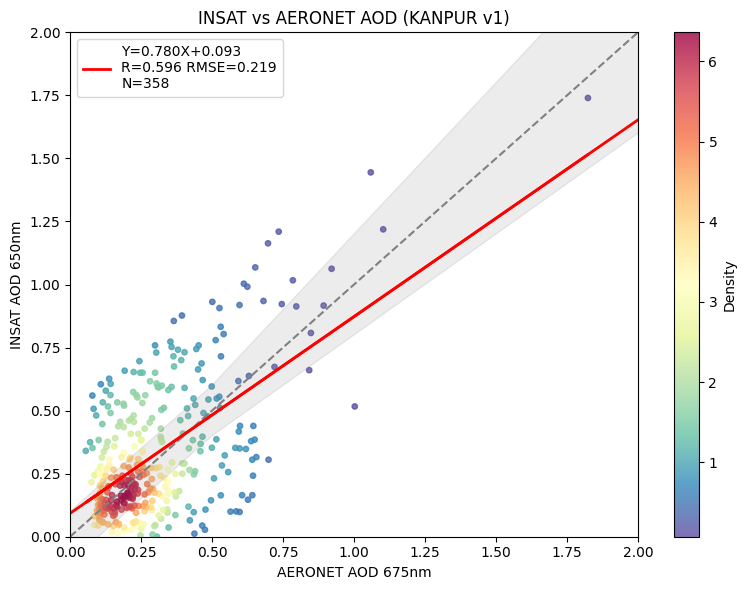

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Remove rows with NaN in any of the relevant columns


# Extract cleaned data
std = cleaned_data['std'].to_numpy()
insat_aod = cleaned_data['Mean_AOD'].to_numpy()
aeronet_aod = cleaned_data['AOD_675nm'].to_numpy()

# Compute density for color coding
xy = np.vstack([aeronet_aod, insat_aod])
z = gaussian_kde(xy)(xy)

# Sort data points by density
idx = z.argsort()
aeronet_aod, insat_aod, z = aeronet_aod[idx], insat_aod[idx], z[idx]

# Perform linear regression
model = LinearRegression()
aeronet_aod_reshaped = aeronet_aod.reshape(-1, 1)
model.fit(aeronet_aod_reshaped, insat_aod)
predicted = model.predict(aeronet_aod_reshaped)

# Calculate regression
slope = model.coef_[0]
intercept = model.intercept_
#r2 = r2_score(insat_aod, predicted)
#rmse =np.sqrt( mean_squared_error(insat_aod, predicted))
r2=correlation
rmse=rmse_direct
N=num_insat_data
# Scatter plot
plt.figure(figsize=(8, 6))
#scatter = plt.scatter(aeronet_aod, insat_aod, c=z, cmap=custom_cmap, s=15, alpha=0.8)
scatter = plt.scatter(aeronet_aod, insat_aod, c=z, cmap='Spectral_r' , s=15, alpha=0.8)
#scatter = plt.scatter(aeronet_aod, insat_aod, c=z, cmap=vibgyor_cmap, s=15, alpha=0.8)
plt.colorbar(scatter, label='Density')

# regression line
plt.plot(aeronet_aod, predicted, color='red',linewidth=2, label=f'Y={slope:.3f}X+{intercept:.3f}\nR={r2:.3f} RMSE={rmse:.3f}\nN={num_insat_data:.0f}')

# 1:1 line
x = np.linspace(0, 3, 100)
y = x
plt.plot(x, y, color='grey', linestyle='--')

# Upper and lower EE lines
#ee_envelope = 0.20 * x + 0.05
ee_envelope = [ np.max([0.1, i*0.2]) for i in x]
upper_ee = x + ee_envelope
lower_ee = x - ee_envelope

# shade region between EE lines
plt.fill_between(x, lower_ee, upper_ee, color='grey', alpha=0.15)


x_extended = np.linspace(0, 2, 100)  
y_extended = slope * x_extended + intercept
plt.plot(x_extended, y_extended, color='red', linewidth=2)

# Set axis limits to include the origin
plt.xlim(0, 2)
plt.ylim(0, 2)

# Customize plot
plt.xlabel('AERONET AOD 675nm')
plt.ylabel('INSAT AOD 650nm')
plt.title('INSAT vs AERONET AOD (KANPUR v1)')
plt.legend()
#plt.grid(alpha=0.3)
plt.tight_layout()
#plt.savefig('plots 123/KANPUR3.png',format='png',dpi=300)
plt.show()

/tmp/ipykernel_121613/4051505451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Date']=pd.to_datetime(cleaned_data['Date'])


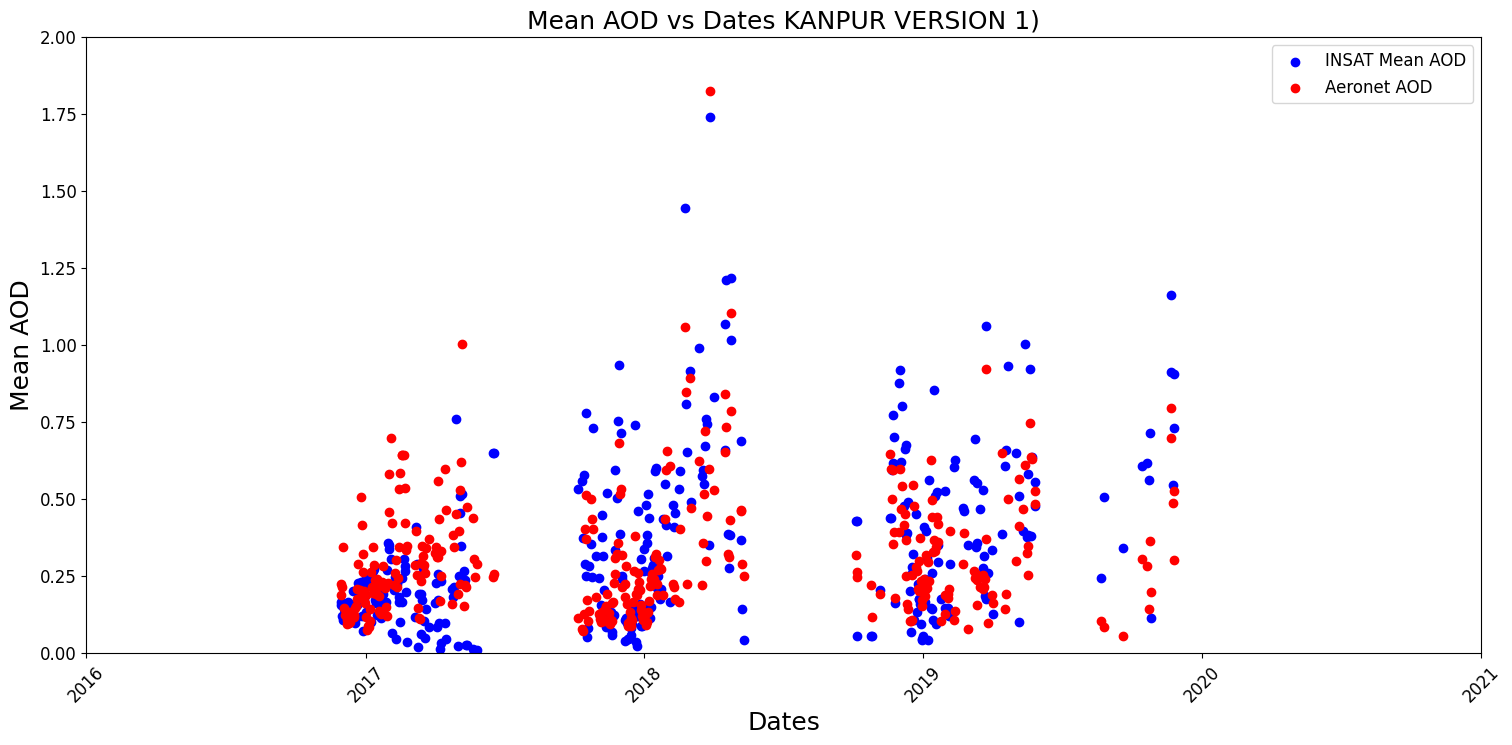

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
cleaned_data['Date']=pd.to_datetime(cleaned_data['Date'])
# Filter the data for dates up to 2019
#merged_df_filtered = merged_df[merged_df['Date'].dt.year <= 2019]

# Set publication-quality font sizes
plt.rcParams.update({
    'axes.labelsize': 14,       # Axis labels
    'axes.titlesize': 16,       # Title size
    'xtick.labelsize': 12,      # X-tick labels
    'ytick.labelsize': 12,      # Y-tick labels
    'legend.fontsize': 12,      # Legend size
    'figure.titlesize': 18,     # Figure title size
    'font.family':'Sans Serif'     # Font style (use 'Times New Roman' or 'Helvetica' as  )
})

# Plotting
plt.figure(figsize=(18, 8))
plt.scatter(cleaned_data['Date'], cleaned_data['Mean_AOD'], color='blue', marker='o', label='INSAT Mean AOD')
plt.scatter(cleaned_data['Date'],cleaned_data['AOD_675nm'], color='red', marker='o', label='Aeronet AOD')
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2020-12-31'))

ax = plt.gca()  # Get current axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY

# Manually set x-axis ticks at July 1st of each year from 2016 to 2020
year_ticks = [pd.Timestamp(f'{year}-01-01') for year in range(2016, 2022)]
ax.set_xticks(year_ticks)
# Add title and labels
plt.title('Mean AOD vs Dates KANPUR VERSION 1)', size=18)
plt.ylabel('Mean AOD', size=18)
plt.xlabel('Dates', size=18)
plt.legend()
plt.ylim(0,2)
# Rotate x-ticks for better readability
plt.xticks(rotation=45)

# Save the plot as a high-resolution PNG file
#plt.savefig("plots 123/KANPUR1.png", format='png', dpi=300)

# Display the plot
plt.show()


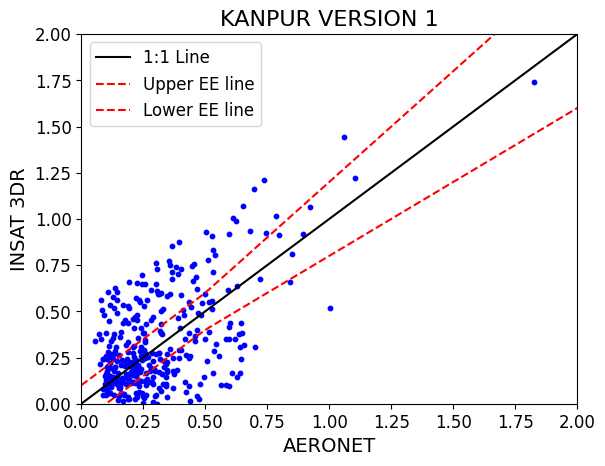

In [7]:
import matplotlib.pyplot as plt
import numpy as np
#upper_bound = (merged_df["AOD_675nm"] * 0.20) + 0.50
#lower_bound = -(upper_bound)

#  1:1 line(if insat and aeronet have same values)
x = np.linspace(0, 3, 100) 
y = x

plt.plot(x, y, label='1:1 Line', color='black', linestyle='-')
#expected error
#ee_envelope = 0.20*x + 0.1
ee_envelope = [ np.max([0.1, i*0.2]) for i in x]
plt.plot(x,x+ ee_envelope, 'r--', label='Upper EE line')
plt.plot(x,x - ee_envelope, 'r--', label='Lower EE line')

# Plot the data points
plt.scatter(cleaned_data['AOD_675nm'], cleaned_data['Mean_AOD'], color='blue', marker='o', s=10)

plt.title("KANPUR VERSION 1")
plt.xlim(0,2)
plt.ylim(0,2)
plt.xlabel("AERONET")
plt.ylabel("INSAT 3DR")
plt.legend()
#plt.savefig("plots 123/KANPUR2.png", format='png', dpi=300) 
plt.show()


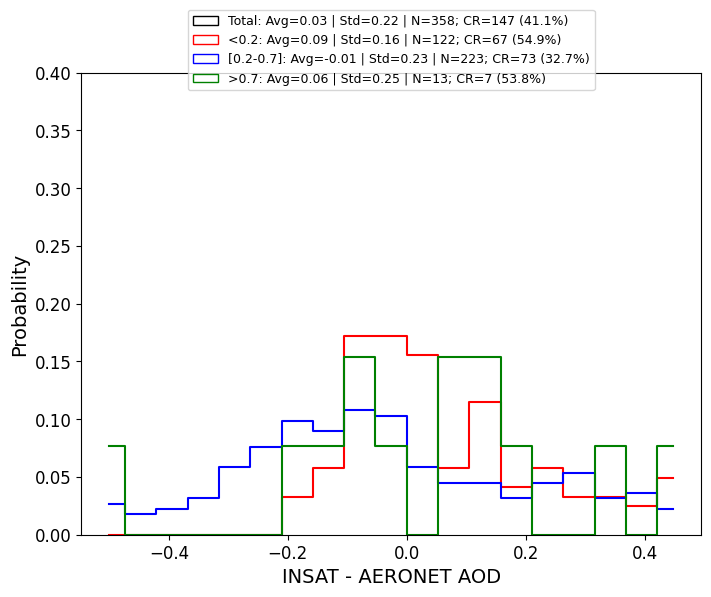

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # For outlined legend boxes

# Filter data to include only entries until 2020
cleaned_data = cleaned_data[cleaned_data['Date'].dt.year <= 2020]

# Calculate the Difference (INSAT - AERONET)
cleaned_data['Difference'] = cleaned_data['Mean_AOD'] - cleaned_data['AOD_675nm']

# Categorize AOD values into ranges
bins = [0, 0.2, 0.7, np.inf]
labels = ['<0.2', '[0.2-0.7]', '>0.7']
cleaned_data['AOD_Category'] = pd.cut(cleaned_data['AOD_675nm'], bins=bins, labels=labels)

# Calculate overall statistics
total_N = cleaned_data['Difference'].count()
total_avg = cleaned_data['Difference'].mean()
total_std = cleaned_data['Difference'].std()
total_CR = (cleaned_data['Difference'].abs() <= np.maximum(0.1, 0.2 * cleaned_data['AOD_675nm'])).sum()


# Start creating the histogram plot
fig, ax = plt.subplots(figsize=(8, 6))

# Define colors for the categories
colors = {'<0.2': 'red', '[0.2-0.7]': 'blue', '>0.7': 'green'}

# Dictionary to store category statistics for the legend
legend_patches = [mpatches.Patch(edgecolor='black', fill=False, linewidth=1, label=f'Total: Avg={total_avg:.2f} | Std={total_std:.2f} | N={total_N}; CR={total_CR} ({total_CR/total_N*100:.1f}%)')]

# Loop through each AOD category and plot the histogram
for category, color in colors.items():
    subset = cleaned_data[cleaned_data['AOD_Category'] == category]['Difference'].dropna()

    # Calculate category statistics
    N = subset.count() 
    avg = subset.mean()
    std = subset.std()
    CR = (subset.abs() <= np.maximum(0.1, 0.2 * cleaned_data.loc[subset.index, 'AOD_675nm'])).sum()

    # Histogram plot#retry 1,list comprehension
    bins=np.linspace(-0.5,0.5,num=20)

    # Create histogram
    counts, bin_edges = np.histogram(subset, bins=bins, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    #bin_width = 1
    ax.plot(bin_edges[:-1], counts * bin_width, drawstyle='steps-mid', color=color)

    # Add to legend with outlined rectangles
    legend_patches.append(mpatches.Patch(edgecolor=color, fill=False, linewidth=1, label=f'{category}: Avg={avg:.2f} | Std={std:.2f} | N={N}; CR={CR} ({CR/N*100:.1f}%)'))

# Set plot labels
ax.set_xlabel('INSAT - AERONET AOD')
ax.set_ylabel('Probability')
#ax.set_xlim(-0.25, 0.25)
vl=0.2
ax.set_ylim(0,0.4)

# Add legend at the top with outlined rectangles
ax.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=9, ncol=1, frameon=True)
#plt.savefig("plots 123/KANPUR4.png", format='png', dpi=300)
# Show the plot
plt.show()


In [9]:
# Select relevant columns
table_data = cleaned_data[['Mean_AOD', 'AOD_675nm', 'Difference']]

# Rename columns for clarity
table_data.columns = ['INSAT AOD', 'AERONET AOD', 'Difference']

# Display the table
table_data
# Show the first 10 rows


,INSAT AOD,AERONET AOD,Difference
176,0.154352,0.188168,-0.033816
177,0.165865,0.223752,-0.057887
178,0.119739,0.213710,-0.093971
179,0.107932,0.342652,-0.234720
181,0.143998,0.144798,-0.000800
...,...,...,...
1257,0.913228,0.796682,0.116546
1258,1.163360,0.697153,0.466207
1260,0.544038,0.487276,0.056762
1261,0.906689,0.526203,0.380486


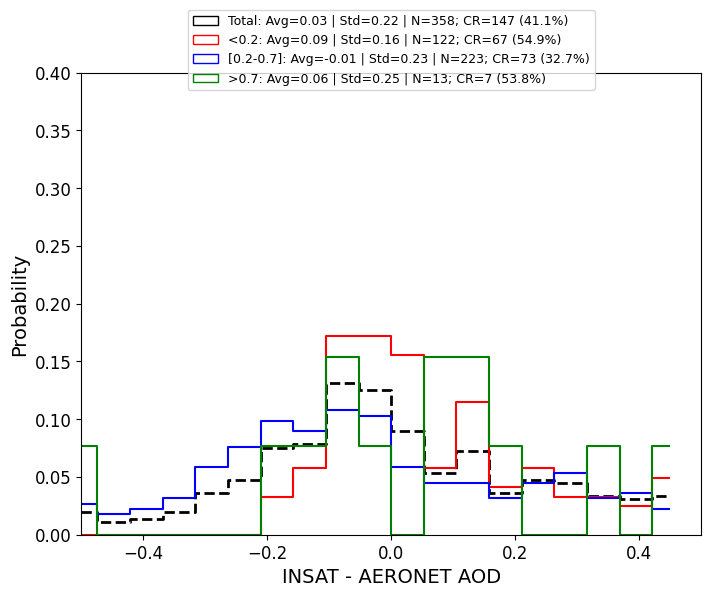

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # For outlined legend boxes

# Filter data to include only entries until 2020
cleaned_data = cleaned_data[cleaned_data['Date'].dt.year <= 2020]

# Calculate the Difference (INSAT - AERONET)
cleaned_data['Difference'] = cleaned_data['Mean_AOD'] - cleaned_data['AOD_675nm']

# Categorize AOD values into ranges
bins = [0, 0.2, 0.7, np.inf]
labels = ['<0.2', '[0.2-0.7]', '>0.7']
cleaned_data['AOD_Category'] = pd.cut(cleaned_data['AOD_675nm'], bins=bins, labels=labels)

# Calculate overall statistics
total_N = cleaned_data['Difference'].count()
total_avg = cleaned_data['Difference'].mean()
total_std = cleaned_data['Difference'].std()
total_CR = (cleaned_data['Difference'].abs() <= np.maximum(0.1, 0.2 * cleaned_data['AOD_675nm'])).sum()
total_CR_percent = (total_CR / total_N * 100) if total_N > 0 else 0  # Avoid division by zero

# Start creating the histogram plot
fig, ax = plt.subplots(figsize=(8, 6))

# Define colors for the categories
colors = {'<0.2': 'red', '[0.2-0.7]': 'blue', '>0.7': 'green'}

# Consistent binning for all histograms
num_bins = 20
bin_range = (-0.5, 0.5)
bins = np.linspace(bin_range[0], bin_range[1], num_bins)

# Plot overall histogram in black (dashed line)
all_data = cleaned_data['Difference'].dropna()
counts, bin_edges = np.histogram(all_data, bins=bins, density=True)
bin_width = bin_edges[1] - bin_edges[0]
ax.plot(bin_edges[:-1], counts * bin_width, drawstyle='steps-mid', color='black', linestyle='dashed', linewidth=2, label='Overall')

# Dictionary to store category statistics for the legend
legend_patches = [
    mpatches.Patch(edgecolor='black', fill=False, linewidth=1, 
                   label=f'Total: Avg={total_avg:.2f} | Std={total_std:.2f} | N={total_N}; CR={total_CR} ({total_CR_percent:.1f}%)')
]

# Loop through each AOD category and plot the histogram
for category, color in colors.items():
    subset = cleaned_data[cleaned_data['AOD_Category'] == category]['Difference'].dropna()

    # Skip empty categories
    if subset.empty:
        continue

    # Calculate category statistics
    N = subset.count() 
    avg = subset.mean()
    std = subset.std()
    #CR = (subset.abs() <= 0.1).sum()
    # Ensure both series are aligned before comparison
    CR = (subset.abs() <= np.maximum(0.1, 0.2 * cleaned_data.loc[subset.index, 'AOD_675nm'])).sum()

    CR_percent = (CR / N * 100) if N > 0 else 0  # Avoid zero-division

    # Create histogram
    counts, bin_edges = np.histogram(subset, bins=bins, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    ax.plot(bin_edges[:-1], counts * bin_width, drawstyle='steps-mid', color=color)

    # Add to legend with outlined rectangles
    legend_patches.append(
        mpatches.Patch(edgecolor=color, fill=False, linewidth=1,
                       label=f'{category}: Avg={avg:.2f} | Std={std:.2f} | N={N}; CR={CR} ({CR_percent:.1f}%)')
    )

# Set plot labels and limits
ax.set_xlabel('INSAT - AERONET AOD')
ax.set_ylabel('Probability')
ax.set_xlim(bin_range)
ax.set_ylim(0, 0.4)

# Add legend at the top with outlined rectangles
ax.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=9, ncol=1, frameon=True)

# Save the figure
# plt.savefig("plots 123/KANPUR4.png", format='png', dpi=300)

# Show the plot
plt.show()


(0.0, 0.4)

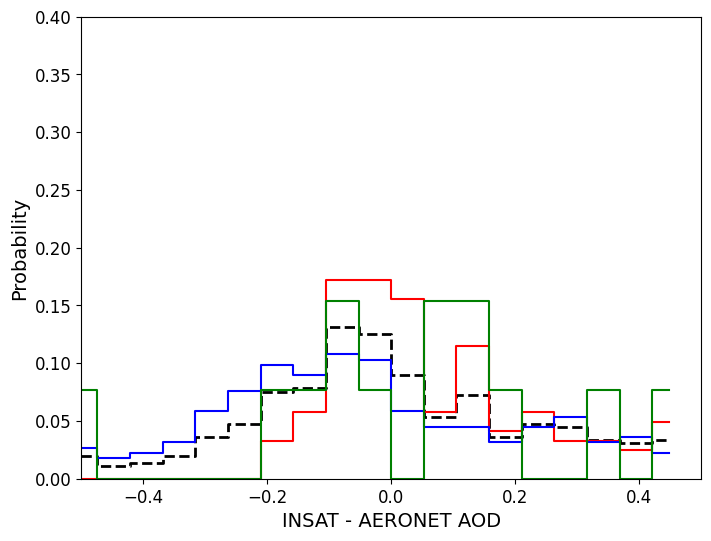

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Filter data to include only entries until 2020
cleaned_data = cleaned_data[cleaned_data['Date'].dt.year <= 2020]

# Calculate the Difference (INSAT - AERONET)
cleaned_data['Difference'] = cleaned_data['Mean_AOD'] - cleaned_data['AOD_675nm']

# Categorize AOD values into ranges
bins = [0, 0.2, 0.7, np.inf]
labels = ['<0.2', '[0.2-0.7]', '>0.7']
cleaned_data['AOD_Category'] = pd.cut(cleaned_data['AOD_675nm'], bins=bins, labels=labels)

# Calculate overall statistics
total_N = cleaned_data['Difference'].count()
total_avg = cleaned_data['Difference'].mean()
total_std = cleaned_data['Difference'].std()
total_CR = (cleaned_data['Difference'].abs() <= 0.1).sum()
total_CR_percent = (total_CR / total_N * 100) if total_N > 0 else 0

# Start creating the histogram plot
fig, ax = plt.subplots(figsize=(8, 6))

# Define colors for the categories
colors = {'<0.2': 'red', '[0.2-0.7]': 'blue', '>0.7': 'green'}

# Consistent binning for all histograms
num_bins = 20
bin_range = (-0.5, 0.5)
bins = np.linspace(bin_range[0], bin_range[1], num_bins)

# Plot overall histogram in black (dashed line)
all_data = cleaned_data['Difference'].dropna()
counts, bin_edges = np.histogram(all_data, bins=bins, density=True)
bin_width = bin_edges[1] - bin_edges[0]
ax.plot(bin_edges[:-1], counts * bin_width, drawstyle='steps-mid', color='black', linestyle='dashed', linewidth=2, label='Overall')

# Dictionary to store category statistics for the legend
legend_patches = [
    mpatches.Patch(edgecolor='black', fill=False, linewidth=1, 
                   label=f'Total: Avg={total_avg:.2f} | Std={total_std:.2f} | N={total_N}; CR={total_CR} ({total_CR_percent:.1f}%)')
]

# Loop through each AOD category and plot the histogram
for category, color in colors.items():
    subset = cleaned_data[cleaned_data['AOD_Category'] == category]['Difference'].dropna()

    # Skip empty categories
    if subset.empty:
        continue

    # Calculate category statistics
    N = subset.count()
    avg = subset.mean()
    std = subset.std()
    # Ensure both series are aligned before comparison
    CR = (subset.abs() <= np.maximum(0.1, 0.2 * subset.index.map(cleaned_data['AOD_675nm']))).sum()

    CR_percent = (CR / N * 100) if N > 0 else 0

    # Create histogram
    counts, bin_edges = np.histogram(subset, bins=bins, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    ax.plot(bin_edges[:-1], counts * bin_width, drawstyle='steps-mid', color=color)

    # Add to legend with outlined rectangles
    legend_patches.append(
        mpatches.Patch(edgecolor=color, fill=False, linewidth=1,
                       label=f'{category}: Avg={avg:.2f} | Std={std:.2f} | N={N}; CR={CR} ({CR_percent:.1f}%)')
    )

# Set plot labels and limits
ax.set_xlabel('INSAT - AERONET AOD')
ax.set_ylabel('Probability')
ax.set_xlim(bin_range)
ax.set_ylim(0, 0.4)

# Add legend at the top with

335    -0.486035
623     0.385692
624    -0.040165
630     0.023590
649    -0.046720
656    -0.083837
676    -0.181878
677     0.474885
683     0.232161
684     0.116062
1016    0.141448
1073    0.176887
1257    0.116546
Name: Difference, dtype: float64

[[], [], [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 

In [6]:
from scipy.stats import pearsonr
aeronet_aod=cleaned_data['AOD_675nm']
insat_aod=cleaned_data['Mean_AOD']
correlation, _ = pearsonr(aeronet_aod, insat_aod)
print(f"Pearson correlation coefficient: {correlation:.3f}")
rmse_direct = np.sqrt(mean_squared_error(aeronet_aod, insat_aod))
print(f"RMSE between AERONET and INSAT AOD: {rmse_direct:.3f}")


NameError: name 'cleaned_data' is not defined

In [11]:
# Count the number of non-null INSAT AOD data points
num_insat_data = cleaned_data['Mean_AOD'].count()
print(f"Number of INSAT AOD data points available: {num_insat_data}")


Number of INSAT AOD data points available: 358
